# Developing Pyreal Applications

In this tutorial, we will be going through the process of putting together a RealApp object for future use.

If you have not already tried Demonstration 1: Using Pyreal, please do so before trying this demo, to better understand the purpose of RealApp objects.

## Scenario Details
### Goals for this Scenario
1. Learn the components of a Pyreal RealApp, and the steps required to create one for your target application
2. Learn about Pyreal's built-in Transformers, and how to make custom, application-specific transformers

### User Details

- **User Role:** ML Engineer for Real Estate Firm
- **Expertise:**
    - **Domain (House Pricing):** Some experience
    - **Machine Learning:** Expert
    - **Explainable ML techniques:** Basic understanding
- **User Goals:**
    1. Understand what features contribute to average block prices in California

### Model and Data Details
- 9 Features
- Predicts average price of block of houses

## Data Loading

We will begin by loading in our data matrix and targets.


In [2]:
from urllib.parse import urljoin
import pandas as pd

AWS_BASE_URL = 'https://pyreal-data.s3.amazonaws.com/'
data_url = urljoin(AWS_BASE_URL, "usability_study/california.csv")
data = pd.read_csv(data_url)

city_url = urljoin(AWS_BASE_URL, "usability_study/cal_cities_lat_long.csv")
cities = pd.read_csv(city_url)

data = data[data["median_house_value"] < 500000]

data = data.sample(5000, random_state=100)  # we will work with a truncated dataset to avoid memory crashes

X = data.drop("median_house_value", axis=1)
y = data["median_house_value"]

data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
12826,-121.44,38.71,25,2336,406.0,1172,408,3.5129,INLAND,101200
12596,-121.48,38.53,43,1378,280.0,708,280,2.3542,INLAND,103900
10778,-117.90,33.65,30,1634,373.0,771,364,3.4125,<1H OCEAN,284100
18837,-122.64,41.73,50,1525,308.0,661,285,2.2206,INLAND,63200
18198,-122.03,37.39,34,2600,650.0,1994,650,4.0223,<1H OCEAN,250200


We will be working with a pretrained model to predict the median house values for each block.

**Run the code below to load in the model.**

In [2]:
import lightgbm
import requests
import os

model_url = urljoin(AWS_BASE_URL, "usability_study/model.model")
r = requests.get(model_url, allow_redirects=True)
open(os.path.join('..', 'data', 'california_housing.model'), 'wb').write(r.content)

model = lightgbm.Booster(model_file=os.path.join('..', 'data', 'california_housing.model'))

## Custom Transformers Basics

Pyreal generates ML explanations using Explainer objects, which take in data Transformers through their `transformer` parameter. These Transformers take in three flags in their initialization, two of which we will use in this tutorial:

- Transformers with a `model=True` flag take data from the original feature space (as we loaded in above) to the feature space used by the model.
- Transformers with an `interpret=True` flag take data from the original feature space to a feature space more readable or interpretable by humans.

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
         For information about the third transformer flag (<code>algorithm</code>), please see the <a href="https://github.com/sibyl-dev/pyreal/blob/dev/tutorials/advanced_explanation_generation.ipynb">advanced explanation generation tutorial.</a>
    </p>
</div>

The Pyreal `transformer` module has some common transformers available for use, but some use-cases may require you to write your own transformer. This can be done by extending the base `Transformer` class.

### Transformer Functions
When defining a custom transformer, you will need to consider three types of functions:
- `data_transform` (*required*): A single function that transforms the data from space A to B.
- `inverse_transform_explanation_XXX` (*optional*): Functions that transform an explanation from space B to A. This type of function only needs to be considered if the transformer is used by the explanation algorithm and leads to the data being more obfuscated/less interpretable (ie, will have the `algorithm` flag set to True and the `interpret` flag set to False)
- `transform_explanation_XXX` (*optional*): Functions that transform an explanation from space A to B. This type of function only needs to be considered if the transformer is used to make data and explanations more interpretable than the algorithm-ready state (ie, will have the `algorithm` flag set to False and the `interpret` flag set to True)

The `transform_explantion` type functions are written per Explanation output type. For this tutorial, we will consider additive local feature contribution and additive global feature importance explanations. At the end of this tutorial, we will consider some special cases.

### Custom Transformer Example 1: Per-Household Averager

Let's take a look at one possible custom transformer we can add, which will average the values of certain features per household. We will follow these steps to write the function:

1. Define the transformer `__init__()` method, using a `super()` call for the parent `Transformer` class. The function can take optional arguments to configure the transformer. We will take in a list of columns to average.
2. Define the `data_transform()` function, which takes an input DataFrame `x` and returns `x` after undergoing the transformation. In this case, we simply divide the selected columns by the households feature.
3. Consider which flags we expect to be used with this transformer. In this case, our transformation will be used for the explanation algorithm, but also makes the data more interpretable, so our flags are `interpret=True` and `algorithm=True`. Therefore, we do not need to define any explanation transform functions for this use case.

**Run the cell below to define the PerHouseholdAverager**


In [3]:
from pyreal.transformers import Transformer

class PerHouseholdAverager(Transformer):
    def __init__(self, columns, **kwargs):
        # columns: the columns to average. Must be list of strings (column names)
        self.columns = columns
        super().__init__(**kwargs)

    def data_transform(self, x):
        # Transform the data by adding a new column from total_[column] called
        #   average_[column]. This feature represents the average value of
        #   [column] per household.
        for column in self.columns:
            name = column.replace("total", "average")
            x[name] = x[column] / x["households"]
        return x

### Custom Transformer Example 2: City Converter

Now, let's take a look at another custom transformer, this one requiring an explanation transform. This transformer will be used to convert latitude/longitude values into city areas, based on the closest city to the given coordinates.

Again, we will follow the following steps:

1. Define the transformer `__init__()` method, using a `super()` call for the parent `Transformer` class. The function can take optional arguments to configure the transformer. In this case, we will not take in any parameters.
2. Define the `data_transform()` function, which takes an input DataFrame `x` and returns `x` after undergoing the transformation. In this case, we convert long/lat values to nearby cities.
3. Consider which flags we expect to be used with this transformer. In this case, our transformation will be used to make the data more interpretable, but will not be fed into the model, so our flags are `interpret=True` and `algorithm=model=False`. Therefore, the `transform_explanation_XXX` functions will be called, but not the `inverse_transform_explanation` functions.
4. Consider the explanation output types you are interested in. For now, let's consider additive local feature contribution and additive global feature importance explanations. These are explanations that provide an importance weighting to each feature, and where these importances can be meaningfully added together to represent the importance of multiple features. We will need to define `transform_explanation_additive_feature_contribution` and `transform_explanation_additive_feature_importance` functions.


<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
         Note that explanation output types are heirarchial, and Pyreal will use the explanation transforms of higher-level types when the lower-level types are not available. For example, if <code>transform_explanation_additive_feature_contribution</code> is not defined, Pyreal will attempt to use <code>transform_explanation_feature_contribution</code>.
    </p>
</div>


In [4]:
from pyreal.types.explanations.feature_based import AdditiveFeatureContributionExplanation, AdditiveFeatureImportanceExplanation

class CityConverter(Transformer):
    def __init__(self, **kwargs):
        self.cities = cities
        super().__init__(**kwargs)

    def data_transform(self, x):
        # Converts latitude/longitude coordinates to closest city name. Note that
        #    we are using a very rough estimate here, assuming constant size.
        flag = False
        if isinstance(x, pd.Series):
            x = x.to_frame().T
            flag = True
        for index, row in self.cities.iterrows():
            lat = row["Latitude"]
            lon = row["Longitude"]
            x.loc[(x["latitude"] > lat-0.1) & (x["latitude"] < lat+0.1) & (x["longitude"] > lon-0.1) & (x["longitude"] < lon+0.1), "city"] = row["Name"]
        x = x.drop("latitude", axis=1)
        x = x.drop("longitude", axis=1)
        if flag:
            x = x.squeeze(axis=0)
        return x

    def transform_explanation_additive_feature_contribution(self, explanation):
        df = explanation.get()  # A DataFrame with one row per instance and one column per feature
        return AdditiveFeatureContributionExplanation(CityConverter.helper_sum_lat_long_columns(df))

    def transform_explanation_additive_feature_importance(self, explanation):
        df = explanation.get()  # A DataFrame with one row and one column per feature
        return AdditiveFeatureImportanceExplanation(CityConverter.helper_sum_lat_long_columns(df))

    def helper_sum_lat_long_columns(explanation):
        # In the case of additive contributions or importances, we can combine the latitude and
        #    longitude explanation contributions by summing to get the city contribution. In this
        #    case, our implementation is almost identical for both types of explanations
        explanation["city"] = explanation["longitude"] + explanation["latitude"]
        explanation = explanation.drop("longitude", axis=1)
        explanation = explanation.drop("latitude", axis=1)
        return explanation

## Using Transformers

In the next code cell, we will using our custom defined transformers, as well as some predefined Pyreal transformers, to generate local and global explanations.

In [5]:
from pyreal.transformers import OneHotEncoder, MultiTypeImputer, fit_transformers
from pyreal import RealApp

# Initialize and fit transformers using fit_transformers
transformers = [MultiTypeImputer(model=True),
                OneHotEncoder(columns="ocean_proximity", model=True),
                PerHouseholdAverager(columns=["total_bedrooms", "total_rooms"], model=True, interpret=True),
                CityConverter(model=False, interpret=True)]
fit_transformers(transformers, X)


realApp = RealApp(model, X_train_orig=X, transformers=transformers)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


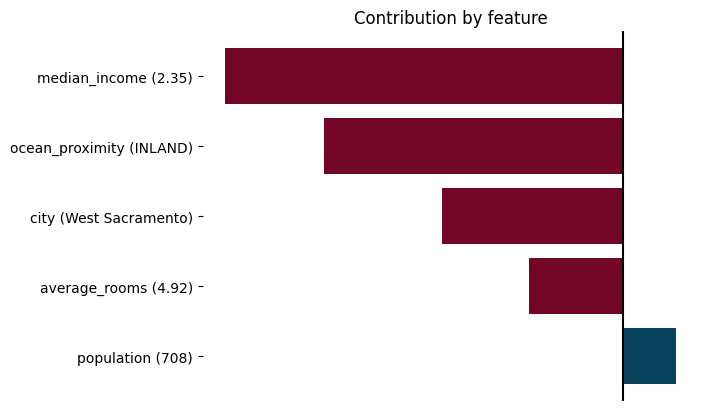

In [11]:
from pyreal import visualize

explanation = realApp.produce_local_feature_contributions(X.iloc[1])
visualize.plot_top_contributors(explanation[0], select_by="absolute", show=True)